## BlackSheep Cookbook Take 2

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis, to answer a research question, of if BMI, age, or country of origin play a role in protein enrichments for patients with Endometrial Cancer.

### Step 1a: Import Dependencies
First, import the necessary dependencies and install cptac through pip.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install cptac
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import importlib
importlib.reload(bf)
importlib.reload(blsh)

Welcome to cptac, a python package for disseminating cancer
proteogenomics data. To view available datasets, enter
'cptac.list_data()'. Extensive tutorials are available at
https://github.com/PayneLab/cptac/tree/master/doc

******
Version: 0.4.5
******


<module 'blackSheepCPTACmoduleCopy' from 'C:\\Users\\Daniel\\Documents\\GitHub\\WhenMutationsMatter\\Daniel\\blackSheepCPTACmoduleCopy.py'>

## Step 1b: Load Data and Choose Omics Table

In [2]:
en = cptac.Endometrial()
proteomics = en.get_proteomics()
phospho = en.get_phosphoproteomics()
clinical = en.get_clinical()

Checking that data files are up-to-date...
100% [..................................................................................] 649 / 649
Data check complete.
endometrial data version: 2.1

Loading acetylproteomics data...
Loading clinical data...
Loading CNA data...
Loading definitions data...
Loading miRNA data...
Loading phosphoproteomics_gene data...
Loading phosphoproteomics_site data...
Loading proteomics data...
Loading somatic data...
Loading somatic_binary data...
Loading transcriptomics_circular data...
Loading transcriptomics_linear data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but analysis may not be
published until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter cptac.embargo() to open the webpage for more details.


In [3]:
#Append Genomics_subtype and MSI_status to en.get_clinical()
df= en.get_derived_molecular()
clinical['Genomics_subtype'] = df['Genomics_subtype'] #Why did I need this again?
clinical['MSI_status'] = df['MSI_status']
print(clinical['Genomics_subtype'].value_counts())

CNV_low     43
MSI-H       25
CNV_high    20
POLE         7
Name: Genomics_subtype, dtype: int64


## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will be testing MSI_status versus BMI in the proteomics dataset, and Histologic_type versus Age in the phosphoproteomics dataset.

In [4]:
#Create a subset copy of the original Clinical DataFrame for proteomics.
annotations_prot = pd.DataFrame(clinical['MSI_status'].copy())

#Create a subset copy of the orignial Clinical DataFrame for phosphoproteomics.
annotations_phospho = pd.DataFrame(clinical['Histologic_type'].copy())

## Step 3: Perform outliers analysis

In [5]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=2.0, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

outliers_phospho = blsh.make_outliers_table(phospho, iqrs=2.0, 
                                            up_or_down='up', 
                                            aggregate=False, 
                                            frac_table=False)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\lib\nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Step 4: Wrap your A/B test into the outliers analysis, and create a table

In [6]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations_prot, 
                                            frac_filter=0.1)

results_phospho = blsh.compare_groups_outliers(outliers_phospho, 
                                               annotations_phospho, 
                                               frac_filter=0.1)

Testing 147 rows for enrichment in MSI_status MSS samples
Testing 292 rows for enrichment in MSI_status MSI-H samples
Testing 41 rows for enrichment in Histologic_type Endometrioid samples
Testing 1550 rows for enrichment in Histologic_type Serous samples


## Step 5: Visualize these enrichments

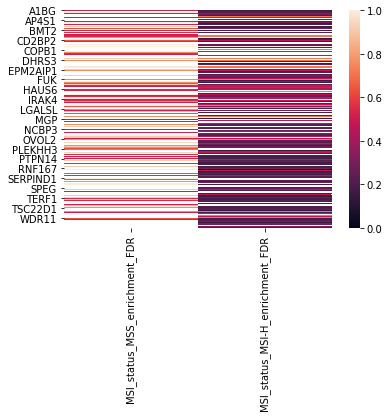

In [104]:
sns.heatmap(results_prot)
plt.show()

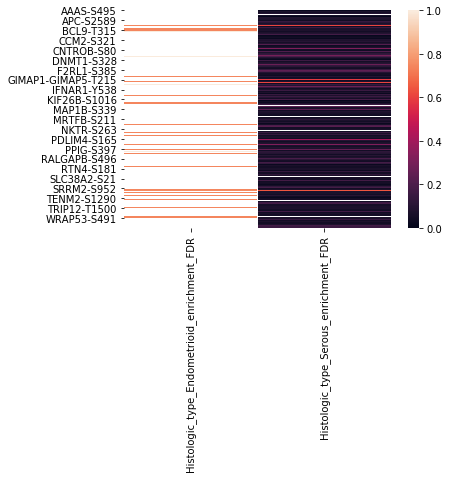

In [105]:
sns.heatmap(results_phospho)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [166]:
#Check for significant columns in proteomics
for col in results_prot.columns:
    bf.significantEnrichments(results_prot, col)

#Check for significant columns in proteomics
for col in results_phospho.columns:
    bf.significantEnrichments(results_phospho, col)

No significant results in MSI_status_MSS

1 significant protein enrichment in MSI_status_MSI-H:

No significant results in Histologic_type_Endometrioid

523 significant protein enrichments in Histologic_type_Serous



In [174]:
#Store the dataframe of significant enrichments
sig_results_MSI = bf.significantEnrichments(results_prot, 
                                            'MSI_status_MSI-H_enrichment_FDR', 
                                            p_value=0.05)

sig_results_Serous = bf.significantEnrichments(results_phospho, 
                                            'Histologic_type_Serous_enrichment_FDR', 
                                             p_value=0.05)

1 significant protein enrichment in MSI_status_MSI-H:

523 significant protein enrichments in Histologic_type_Serous



As mentioned in our paper, we see a significant upregulation in RPL22L1 within the proteomics dataset for patients with MSI-H status.

In [170]:
print('RPL22L1' in sig_results_MSI.index)
sig_results_MSI

True


,MSI_status_MSI-H_P_values
RPL22L1,6.367752e-08


Additionally, as mentioned in our paper, we see a significant upregulation of TP53BP1-S1763 in the phosphoproteomics dataset for patients with Serous tumors.  However, we initially found a significant upregulation of CHEK2-S163 in the phosphoproteomics dataset for Serous tumors, but our black sheep analysis did not return the same result.

In [177]:
print('TP53BP1-S1763' in sig_results_Serous.index)
print('CHEK2-S163' in sig_results_Serous.index)

True
False
False
